In [3]:
import pandas as pd
import torch
import numpy as np

In [4]:
all_data = pd.read_csv('location_data.csv', index_col=0)

print(all_data)

                        id   latitude  longitude   price
0                     6499  38.697500  -9.197680    73.0
1                    25659  38.712410  -9.127060   106.0
2                    29396  38.711560  -9.129870    75.0
3                    29720  38.711080  -9.159790  1065.0
4                    29915  38.745710  -9.152640    95.0
...                    ...        ...        ...     ...
24259  1371008748532246224  38.721219  -9.167266  7411.0
24260  1371091268401865721  38.717077  -9.147289   200.0
24261  1371216308686882761  38.732713  -9.145716   110.0
24262  1371223704329486155  38.700770  -9.168950    59.0
24263  1371344702478038562  38.698704  -9.421072   200.0

[21079 rows x 4 columns]


In [5]:
all_data = all_data[['latitude', 'longitude', 'price']].to_numpy()

In [6]:
print(all_data)

[[ 38.6975     -9.19768    73.       ]
 [ 38.71241    -9.12706   106.       ]
 [ 38.71156    -9.12987    75.       ]
 ...
 [ 38.7327131  -9.1457157 110.       ]
 [ 38.70077    -9.16895    59.       ]
 [ 38.6987035  -9.4210724 200.       ]]


In [7]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


In [8]:
idx = np.arange(all_data.shape[0])
idx_shuffled = np.random.permutation(idx)

In [9]:
train_data_ratio = 0.8

train_idx = idx_shuffled[:int(0.8 * idx_shuffled.shape[0])]
test_idx = idx_shuffled[int(0.8 * idx_shuffled.shape[0]):]

train_data_raw = all_data[train_idx]
test_data_raw = all_data[test_idx]

print(train_data_raw)
print(test_data_raw)

[[ 38.74472     -9.14228    125.        ]
 [ 38.7213458   -9.1376525   56.        ]
 [ 38.69661256  -9.19352401 453.        ]
 ...
 [ 38.71094     -9.13873    206.        ]
 [ 38.80164116  -9.37714923  79.        ]
 [ 38.71365     -9.14164    190.        ]]
[[ 38.86907    -9.42902    40.       ]
 [ 38.70367    -9.38974   180.       ]
 [ 38.7115983  -9.1292756  72.       ]
 ...
 [ 38.71738    -9.13153    99.       ]
 [ 38.708694   -9.4223755  48.       ]
 [ 38.71042    -9.13816    93.       ]]


In [10]:
# normalize data

means = np.mean(train_data_raw, axis=0)
std_devs = np.std(train_data_raw, axis = 0)

def y_normalize(y):
    return (y - means[2]) / std_devs[2]

In [11]:
from torch.utils.data import Dataset
class LocationDataset(Dataset):

    def __init__(self, data, means, std_devs):
        self.data = data
        self.means = means
        self.std_devs = std_devs
        self.n_datapoints = self.data.shape[0]

    def normalize(self, data):
        data = (data - self.means) / self.std_devs
        return data

    def __len__(self):
        return self.n_datapoints

    def __getitem__(self, idx):
        data = self.data[idx]
        data = self.normalize(data)
        X, y = data[:2], data[2]
        return X, y

In [12]:
train_dataset = LocationDataset(data=train_data_raw, means=means, std_devs=std_devs)
test_dataset = LocationDataset(data=test_data_raw, means=means, std_devs=std_devs)

In [13]:
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
  """ method to train the model """

  model.train()
  training_losses = []
  for batch, (X, y) in enumerate(dataloader):

    y = y.float()
    y = y_normalize(y)
    optimizer.zero_grad()
    # make prediction and calculate loss
    y_pred = model(X)
    y_pred = y_pred.flatten()
    y = y.flatten()
    loss = loss_fn(y_pred, y)

    training_losses.append(loss.item())

    # backward pass
    loss.backward()
    # gradient descent
    optimizer.step()
  
  # computing train loss and accuracy
  train_loss = sum(training_losses) / len(training_losses)

  return train_loss


def validate(dataloader, model, loss_fn, device, master_bar):
  """ method to compute the metrics on the validation set """
  
  model.eval()
  val_losses = []

  for batch, (X, y) in enumerate(dataloader):
    
    y = y.float()
    # make prediction
    y_pred = model(X)
    y_pred = y_pred.flatten()
    y_normalize(y)
    y = y.flatten()
    batch_loss = loss_fn(y_pred, y)
    val_losses.append(batch_loss.item())

  # calculate average loss and accuracy
  val_loss = sum(val_losses) / len(val_losses)

  return val_loss
    

In [14]:
from tqdm import trange
def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
  """ method to run the training procedure """
  # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
  epochs = []
  for epoch in trange(num_epochs):
    train_loss = train(train_dataloader, optimizer, model, loss_function, device, master_bar=None)
    val_loss = validate(val_dataloader, model, loss_function, device, master_bar=None)

    data = {
      "train_loss": train_loss,
      "validation_loss": val_loss,
    }
    epochs.append(data)

  return epochs

In [15]:
import torch.nn as nn
class LargeNeuralNet(torch.nn.Module):

    def __init__(self):
        super(LargeNeuralNet, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2, 1)
        )

    def forward(self, x):
        x = x.float()
        pred = self.linear_relu_stack(x)
        return pred

In [16]:
model = LargeNeuralNet()

lr = 1e-4
batch_size = 264
num_epochs = 500




optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=1e-6)
loss_function = nn.MSELoss()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


epoch_data = run_training(model=model, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs=num_epochs, train_dataloader=train_loader, val_dataloader=test_loader)

100%|██████████| 500/500 [00:50<00:00,  9.97it/s]


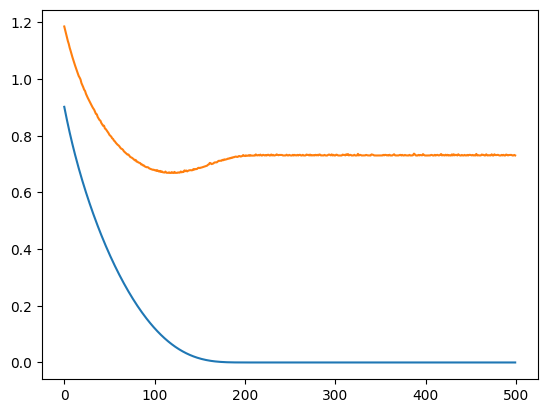

In [17]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(epoch_data))], [epoch_data[i]['train_loss'] for i in range(len(epoch_data))])
plt.plot([i for i in range(len(epoch_data))], [epoch_data[i]['validation_loss'] for i in range(len(epoch_data))])
plt.show()

In [18]:
from sklearn import linear_model
def sklearn_regression(X_test, X_train, y_train):


    # ---------------- INSERT CODE ----------------------
    model = linear_model.LinearRegression().fit(X_train, y_train)
    weights = model.get_params()
    y_pred = model.predict(X_test)
    


    # ---------------- END CODE -------------------------

    return y_pred, model

In [19]:
X_train, y_train = train_data_raw[:, :2], train_data_raw[:, 2]
X_test, y_test = test_data_raw[:, :2], test_data_raw[:, 2]

y_pred, linear_model = sklearn_regression(X_test, X_train, y_train)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(mse)

237188.29305415193


In [21]:
slope = linear_model.coef_
intercept = linear_model.intercept_

print(slope)
print(intercept)

[  16.11990083 -179.62073349]
-2119.7732636330697


In [28]:
all_data = pd.read_csv('location_data.csv', index_col=0)
print(all_data)
all_data = all_data.to_numpy()
print(all_data)

                        id   latitude  longitude   price
0                     6499  38.697500  -9.197680    73.0
1                    25659  38.712410  -9.127060   106.0
2                    29396  38.711560  -9.129870    75.0
3                    29720  38.711080  -9.159790  1065.0
4                    29915  38.745710  -9.152640    95.0
...                    ...        ...        ...     ...
24259  1371008748532246224  38.721219  -9.167266  7411.0
24260  1371091268401865721  38.717077  -9.147289   200.0
24261  1371216308686882761  38.732713  -9.145716   110.0
24262  1371223704329486155  38.700770  -9.168950    59.0
24263  1371344702478038562  38.698704  -9.421072   200.0

[21079 rows x 4 columns]
[[ 6.49900000e+03  3.86975000e+01 -9.19768000e+00  7.30000000e+01]
 [ 2.56590000e+04  3.87124100e+01 -9.12706000e+00  1.06000000e+02]
 [ 2.93960000e+04  3.87115600e+01 -9.12987000e+00  7.50000000e+01]
 ...
 [ 1.37121631e+18  3.87327131e+01 -9.14571570e+00  1.10000000e+02]
 [ 1.37122370e+18

In [37]:
predictions = [all_data[i][1] * slope[0] for i in range(all_data.shape[0])]
print(predictions)

[np.float64(623.7998623949424), np.float64(624.0402101163278), np.float64(624.0265082006217), np.float64(624.018770648223), np.float64(624.5770028139892), np.float64(624.8761881734065), np.float64(624.0113554938408), np.float64(624.0327949619457), np.float64(623.902707362242), np.float64(624.2797518426715), np.float64(623.8430637291686), np.float64(624.1364459242869), np.float64(623.8506400825592), np.float64(623.9895936277194), np.float64(624.0448848875686), np.float64(624.0784142812964), np.float64(623.9776649011048), np.float64(624.1774090559868), np.float64(624.0110330958242), np.float64(624.0495596588095), np.float64(624.1430550836275), np.float64(624.2409028816696), np.float64(624.0510104498843), np.float64(624.0173198571482), np.float64(624.1312875560211), np.float64(624.0160302650818), np.float64(624.1369295213118), np.float64(624.0493984598013), np.float64(624.0394041212862), np.float64(624.0679363457565), np.float64(624.1337055411457), np.float64(624.0385981262448), np.float6

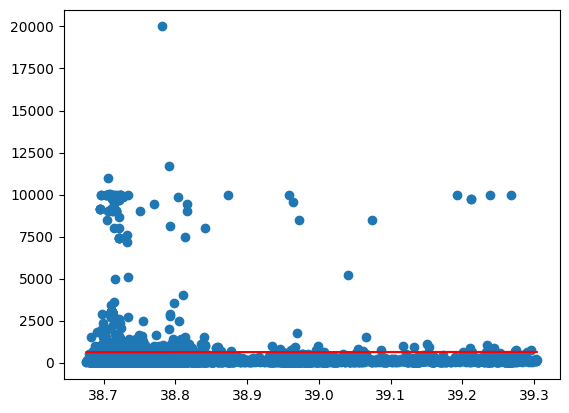

In [39]:
plt.scatter(all_data[:, 1], all_data[:, -1])
plt.plot(all_data[:, 1], predictions, color='red')
plt.show()

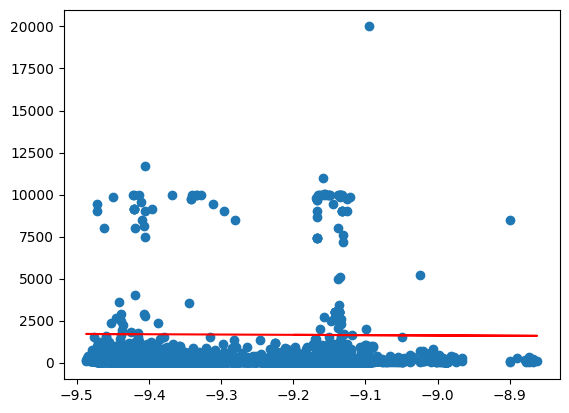

In [40]:
predictions = [all_data[i][2] * slope[1] for i in range(all_data.shape[0])]

plt.scatter(all_data[:, 2], all_data[:, -1])
plt.plot(all_data[:, 2], predictions, color='red')
plt.show()